Housing price prediction
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to a north-south railroad. House price negotiations often have a lot of influencing factors and not just the number of bedrooms or the position of the kitchen.

Take the given dataset with 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. In this hackathon, predict the final price of each home. 

The application should be modeled using Machine Learning, you may explore libraries such as PySpark. Apply containerization principles as a better software engineering practice. You may explore Kafka server for streaming the data.

The model can be deployed using Docker containers for scalability.

Dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

Keywords: ML at scale, feature engineering, regression, random forest, gradient boosting, Distributed ML, Spark, Kafka, Containers

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#!pip install findspark

In [3]:
# import findspark
# findspark.init()
# findspark.find()

In [4]:
from pyspark.sql import DataFrame, SparkSession

In [5]:
from functools import reduce

In [6]:
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark import SparkFiles

In [7]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import numpy as np

In [10]:
import pandas as pd

In [11]:
def get_null_counts(py_df):
    """Computes the value count of each column and reports null value count """
    results = {}
    for cname,ctype in py_df.dtypes:      
        results[cname] = py_df.where( py_df[cname].isNull() ).count()    
    null_counts= {k:v for k,v in results.items() if v!=0 }  
    return null_counts


In [12]:
def plot_dataset(dataset,features ,response_column,log=False):
    """Plot regplot base on feature and response column"""
    fig = plt.figure(figsize=(10,20))

   
    for subplot_index ,i in enumerate(range(0,len(features))):
        if(features[i] not in  (response_column ,'Id')):
            ax = fig.add_subplot(9, 4,  subplot_index + 1)
            if log:
                ax.set(xscale="log",yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.regplot(x=features[i],y= response_column , marker="+", data = dataset,ax=ax)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            plt.tight_layout()
 
    plt.show()

In [13]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=90)

In [14]:
spark = SparkSession.builder.appName("HousePrices").getOrCreate()

In [15]:
train_file = "house-prices/train.csv"

In [16]:
test_file = "house-prices/test.csv"

In [17]:
sdv_file  = "house-prices/train_sdv.csv"

In [18]:
test_struct_fields =  [
 StructField('Id', IntegerType(), True),
 StructField('MSSubClass', IntegerType(), True),
 StructField('MSZoning', StringType(), True),
 StructField('LotFrontage', IntegerType(), True),
 StructField('LotArea', IntegerType(), True),
 StructField('Street', StringType(), True),
 StructField('Alley', StringType(), True),
 StructField('LotShape', StringType(), True),
 StructField('LandContour', StringType(), True),
 StructField('Utilities', StringType(), True),
 StructField('LotConfig', StringType(), True),
 StructField('LandSlope', StringType(), True),
 StructField('Neighborhood', StringType(), True),
 StructField('Condition1', StringType(), True),
 StructField('Condition2', StringType(), True),
 StructField('BldgType', StringType(), True),
 StructField('HouseStyle', StringType(), True),
 StructField('OverallQual', IntegerType(), True),
 StructField('OverallCond', IntegerType(), True),
 StructField('YearBuilt', IntegerType(), True),
 StructField('YearRemodAdd', IntegerType(), True),
 StructField('RoofStyle', StringType(), True),
 StructField('RoofMatl', StringType(), True),
 StructField('Exterior1st', StringType(), True),
 StructField('Exterior2nd', StringType(), True),
 StructField('MasVnrType', StringType(), True),
 StructField('MasVnrArea', IntegerType(), True),
 StructField('ExterQual', StringType(), True),
 StructField('ExterCond', StringType(), True),
 StructField('Foundation', StringType(), True),
 StructField('BsmtQual', StringType(), True),
 StructField('BsmtCond', StringType(), True),
 StructField('BsmtExposure', StringType(), True),
 StructField('BsmtFinType1', StringType(), True),
 StructField('BsmtFinSF1', IntegerType(), True),
 StructField('BsmtFinType2', StringType(), True),
 StructField('BsmtFinSF2', IntegerType(), True),
 StructField('BsmtUnfSF', IntegerType(), True),
 StructField('TotalBsmtSF', IntegerType(), True),
 StructField('Heating', StringType(), True),
 StructField('HeatingQC', StringType(), True),
 StructField('CentralAir', StringType(), True),
 StructField('Electrical', StringType(), True),
 StructField('1stFlrSF', IntegerType(), True),
 StructField('2ndFlrSF', IntegerType(), True),
 StructField('LowQualFinSF', IntegerType(), True),
 StructField('GrLivArea', IntegerType(), True),
 StructField('BsmtFullBath', IntegerType(), True),
 StructField('BsmtHalfBath', IntegerType(), True),
 StructField('FullBath', IntegerType(), True),
 StructField('HalfBath', IntegerType(), True),
 StructField('BedroomAbvGr', IntegerType(), True),
 StructField('KitchenAbvGr', IntegerType(), True),
 StructField('KitchenQual', StringType(), True),
 StructField('TotRmsAbvGrd', IntegerType(), True),
 StructField('Functional', StringType(), True),
 StructField('Fireplaces', IntegerType(), True),
 StructField('FireplaceQu', StringType(), True),
 StructField('GarageType', StringType(), True),
 StructField('GarageYrBlt', IntegerType(), True),
 StructField('GarageFinish', StringType(), True),
 StructField('GarageCars', IntegerType(), True),
 StructField('GarageArea', IntegerType(), True),
 StructField('GarageQual', StringType(), True),
 StructField('GarageCond', StringType(), True),
 StructField('PavedDrive', StringType(), True),
 StructField('WoodDeckSF', IntegerType(), True),
 StructField('OpenPorchSF', IntegerType(), True),
 StructField('EnclosedPorch', IntegerType(), True),
 StructField('3SsnPorch', IntegerType(), True),
 StructField('ScreenPorch', IntegerType(), True),
 StructField('PoolArea', IntegerType(), True),
 StructField('PoolQC', StringType(), True),
 StructField('Fence', StringType(), True),
 StructField('MiscFeature', StringType(), True),
 StructField('MiscVal', IntegerType(), True),
 StructField('MoSold', IntegerType(), True),
 StructField('YrSold', IntegerType(), True),
 StructField('SaleType', StringType(), True),
 StructField('SaleCondition', StringType(), True),
]

In [19]:
COLS_TO_UPPER = ['ExterQual', 'ExterCond', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtQual', 'BsmtCond',
                 'HeatingQC', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure','MSSubClass','SaleCondition','Fence']

COLS_TO_INT = ['BsmtFinType1', 'BsmtFinType2','ExterQual', 'ExterCond', 'KitchenQual', 'FireplaceQu','GarageQual', 'PoolQC',
               'BsmtQual','BsmtCond','HeatingQC','GarageCond','GarageFinish','BsmtExposure','MSSubClass','SaleCondition','Fence']

QUALITY_COLS =['ExterQual', 'ExterCond', 'KitchenQual', 'FireplaceQu','GarageQual', 'PoolQC','BsmtQual','BsmtCond','HeatingQC','GarageCond']

ORDINAL_CATEGORY_FEATURES = ['GarageYrBlt','MoSold','YrSold']

EXCLUDE_COLS  = ['SalePrice','LogSalePrice','Id']
BASEMENT_FINISH_CONVERTER ={ 'NO BASEMENT':'1', 'NA': '1', 'UNF':'2', 'LWQ':'3','REC':'4','BLQ':'5','ALQ':'6','GLQ':'7'}
GARAGE_FINISH_MAP={'NA': '1', "UNF": '2', "RFN": '3', "FIN": '4'} 
QUALITY_CONVERTER = {'NA':'1','NO FIREPLACE':'1','NO POOL':'1','NO BASEMENT':'1','NO GARAGE':'1',
                     'PO':'2', 'FA':'3','TA':'4' ,'GD':'5','EX' :'6'}

BSMTEXPOSURE_MAP = { 'NA':'1' ,'NO':'2','MN':'3','AV':'4','GD':'5'}
MSSUBCLASS_MAP = {'30':'1','180':'2','45':'2','190':'2','90':'2','150':'2','160':'2',
                  '50':'3','85':'3','40':'3','70':'4','80':'4','20':'4','75':'4','120':'4','60':'5'}
SALECONDITION_MAP ={'ABNORML': '2', 'ALLOCA': '2', 'ADJLAND': '2', 'FAMILY': '2', 'NORMAL': '1', 'PARTIAL': '1'}
FENCE_MAP ={'NA': '1', "MNWW": '2', "GDWO": '3', "MNPRV": '4', "GDPRV": '5'} 

In [20]:
train_schema = StructType( test_struct_fields + [StructField('SalePrice', IntegerType(), True)])

In [21]:
test_schema = StructType( test_struct_fields)

In [22]:
df = spark.read.csv(train_file,schema = train_schema, header= True)

In [23]:
sdv_df = spark.read.csv(sdv_file,schema = train_schema, header= True)

In [24]:
test_df = spark.read.csv(test_file,schema = test_schema,  header= True)

In [25]:
dfs = [df, sdv_df]

df= reduce(DataFrame.unionAll, dfs)

print(f"number of rows: {df.count()} and number of columns: {len(df.columns)}")

number of rows: 2960 and number of columns: 81


In [26]:
df.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

### EDA 

In [27]:
### LotFrontage ,MasVnrArea, GarageYrBlt has nulls

In [28]:
pdf = df.toPandas()

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

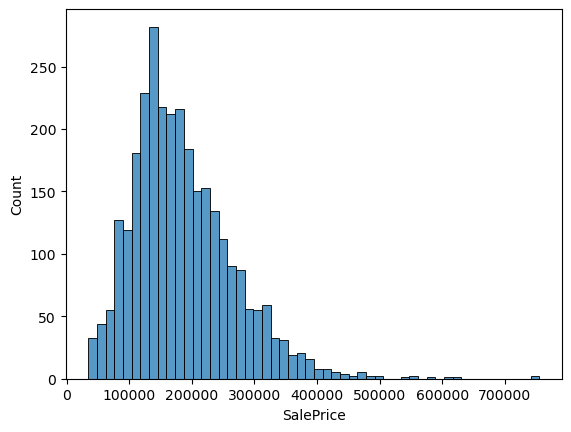

In [29]:
sns.histplot(pdf,x="SalePrice")

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

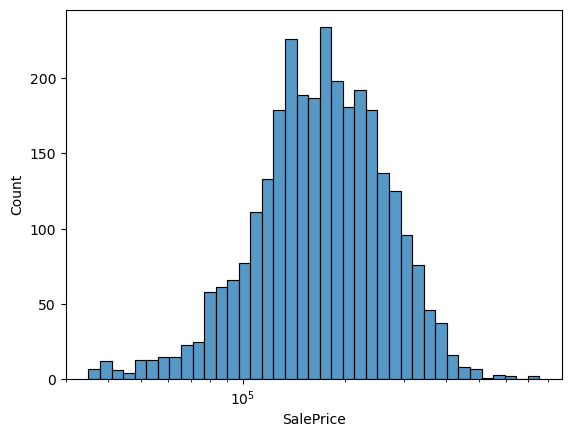

In [30]:
sns.histplot(pdf,x="SalePrice",log_scale=True)

### Inference ,Converting SalePrice to log will make distribution centered

In [31]:
bath_cols = ["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]

In [32]:
# from pyspark.ml.feature import Imputer

# imputer = Imputer(
#     inputCols = serialize_impute_cols,
#     outputCols = [f"{k}_imputed" for k in test_null_counts.keys()]
# ).setStrategy("mean")

### Check for nulls and impute them. 
### For reference , spark treats strings with NA as values rather than pandas in which treats them null 

In [33]:
null_counts = get_null_counts(df)
null_counts

{'LotFrontage': 480, 'MasVnrArea': 17, 'GarageYrBlt': 145}

In [34]:
test_null_counts = get_null_counts(test_df)

In [35]:
test_null_counts

{'LotFrontage': 227,
 'MasVnrArea': 15,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'GarageYrBlt': 78,
 'GarageCars': 1,
 'GarageArea': 1}

In [36]:
IMPUTE_COLS  = list(test_null_counts.keys())

In [37]:
def impute_nulls(df):
    """function to Impute nulls and returns dataframe"""
    df = df.na.fill(value=0,subset=IMPUTE_COLS)
    return df 

In [38]:
df = impute_nulls(df)

### EDA of various features of the  dataset

In [39]:
category_features = [f.name for f in df.schema.fields if isinstance(f.dataType, T.StringType)]
ordinal_category_features = ['OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold','MSSubClass',]
continuous_features = [ f.name for f in df.schema.fields if f.name not in category_features+['SalePrice','Id','MSSubClass']]

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


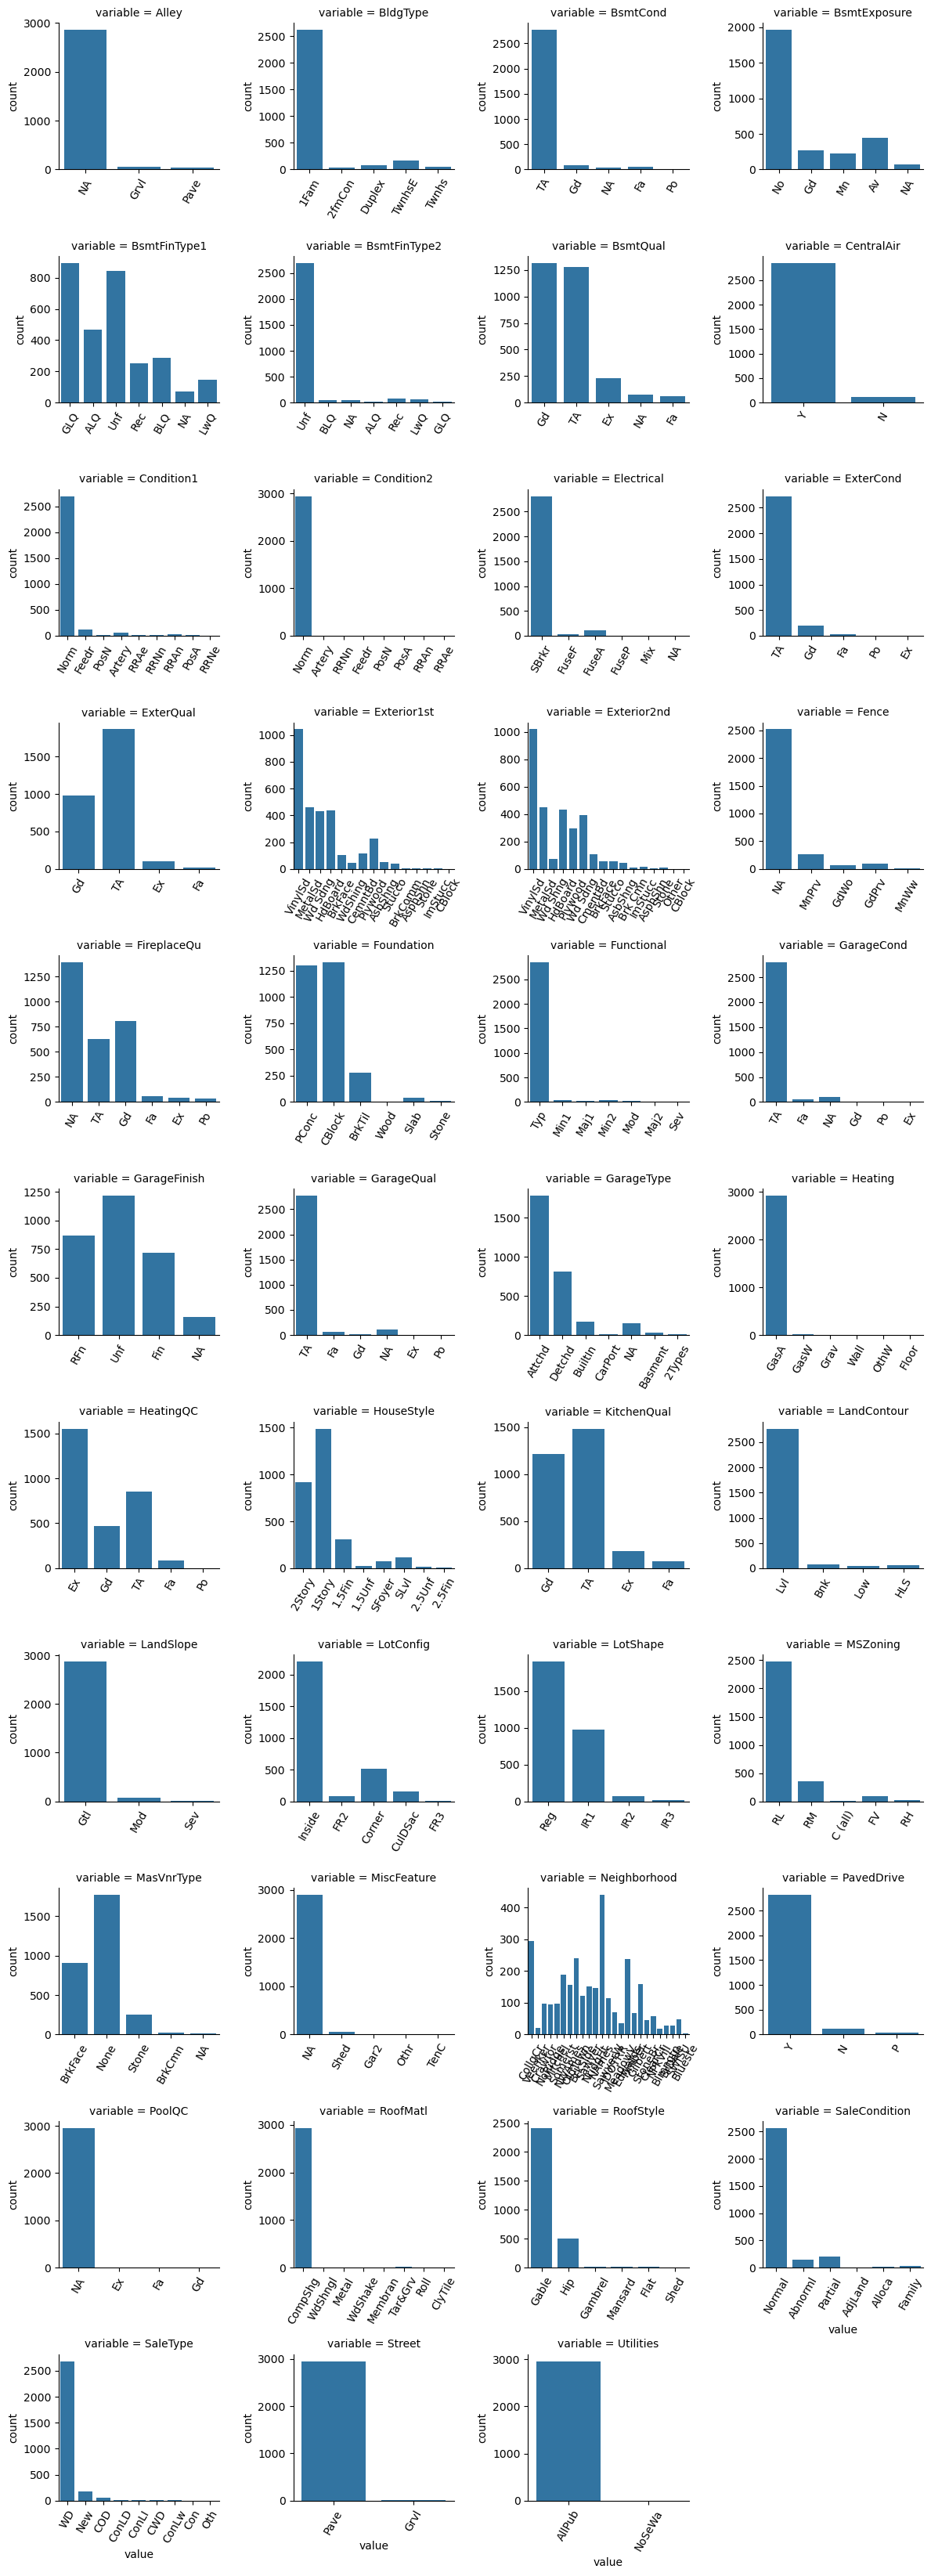

In [40]:
f = pd.melt(pdf, value_vars=sorted(category_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

### Inferences  
#### Street, Utilities ,PoolQC can be dropped

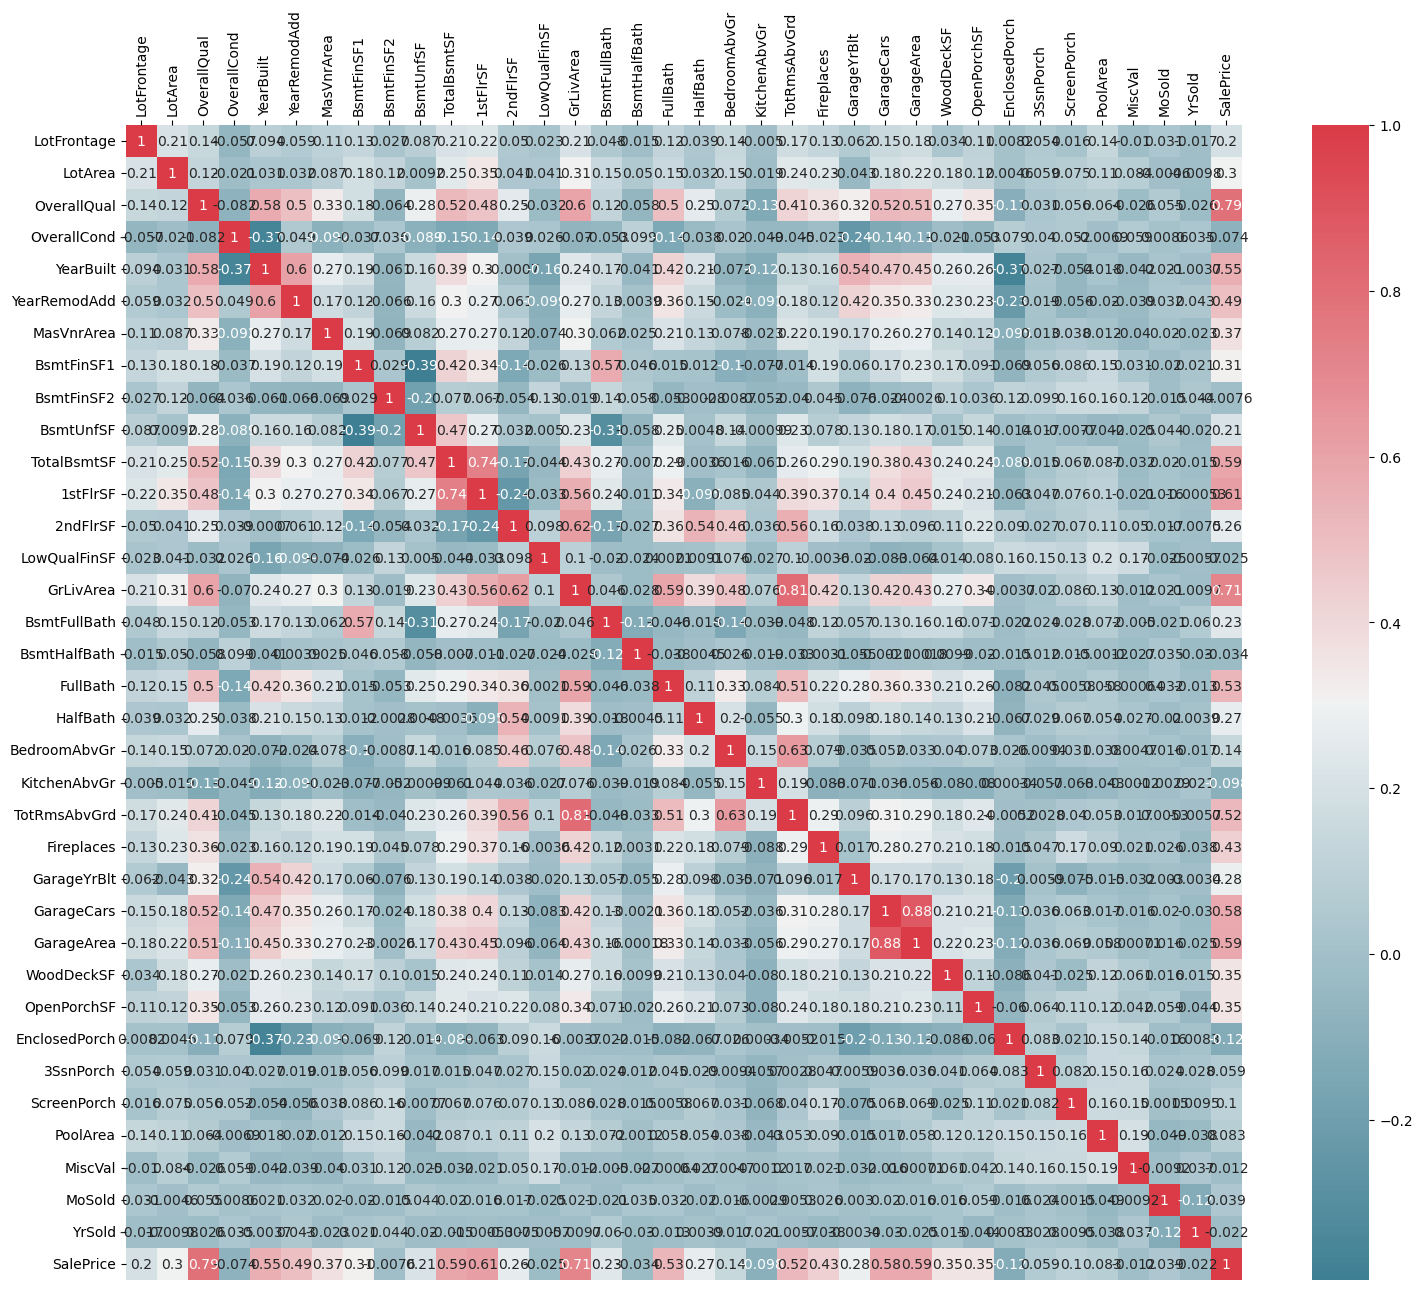

In [41]:
continuous_df = pdf[continuous_features+ ["SalePrice"]]
correlation = continuous_df.corr()
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap ,annot=True)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()


In [42]:
len(list(continuous_df.columns))

36

/tmp/ipykernel_39232/2025180190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continuous_df["SalePrice"]= np.log1p(continuous_df["SalePrice"])


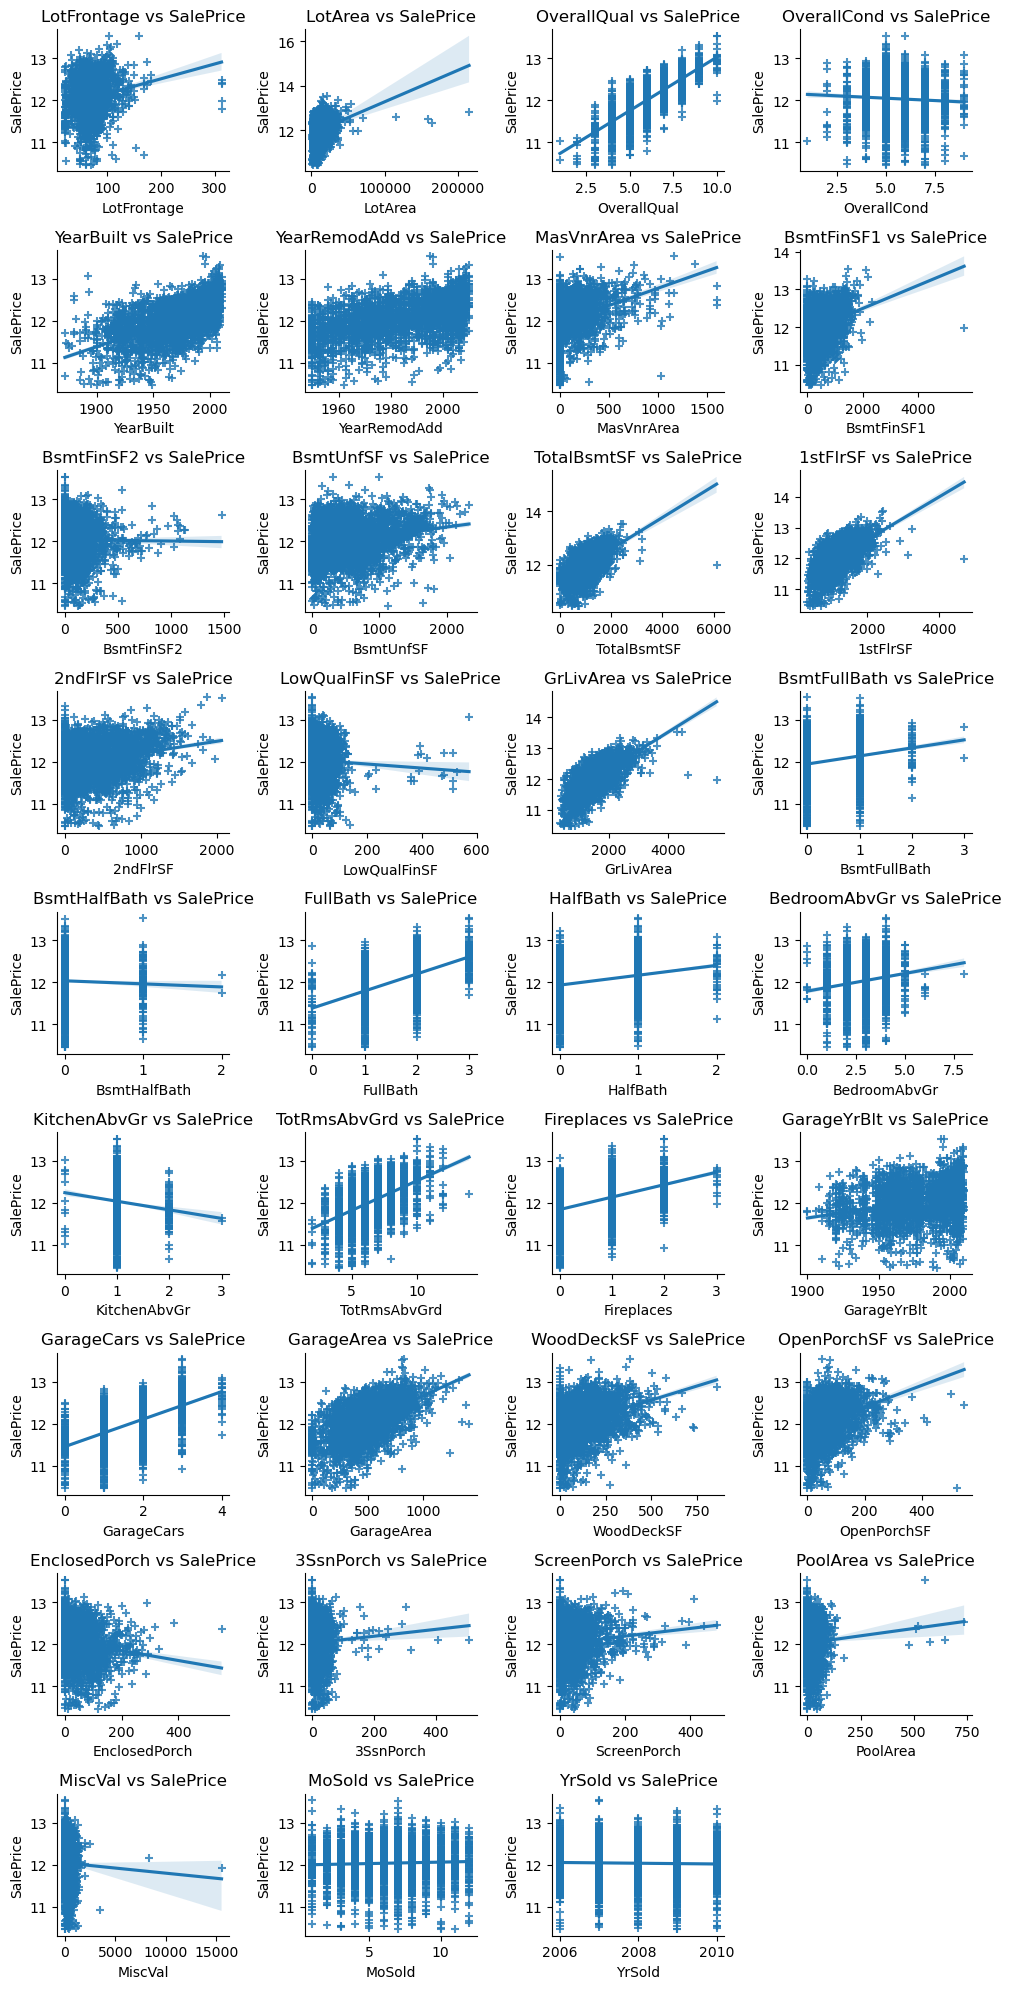

In [43]:
continuous_df["SalePrice"]= np.log1p(continuous_df["SalePrice"])    
plot_dataset(continuous_df,list(continuous_df.columns),"SalePrice")

In [44]:
### What is the impact of Neighborhood on SalePrice

In [45]:
neigbourhood_saleprice = pdf.groupby('Neighborhood').agg({'SalePrice':'mean'}).reset_index()
neigbourhood_saleprice = pd.DataFrame(neigbourhood_saleprice).sort_values(by=['SalePrice'])
neigbourhood_saleprice 

,Neighborhood,SalePrice
2,BrDale,148562.285714
17,OldTown,149769.645833
9,IDOTRR,151536.042254
10,MeadowV,154601.857143
12,NAmes,157905.325000
18,SWISU,158479.170213
7,Edwards,160477.491597
19,Sawyer,163624.388158
3,BrkSide,166692.344262
11,Mitchel,176456.494845


In [46]:
box_features = category_features+['SalePrice']

In [47]:
cat_data = pdf[box_features]

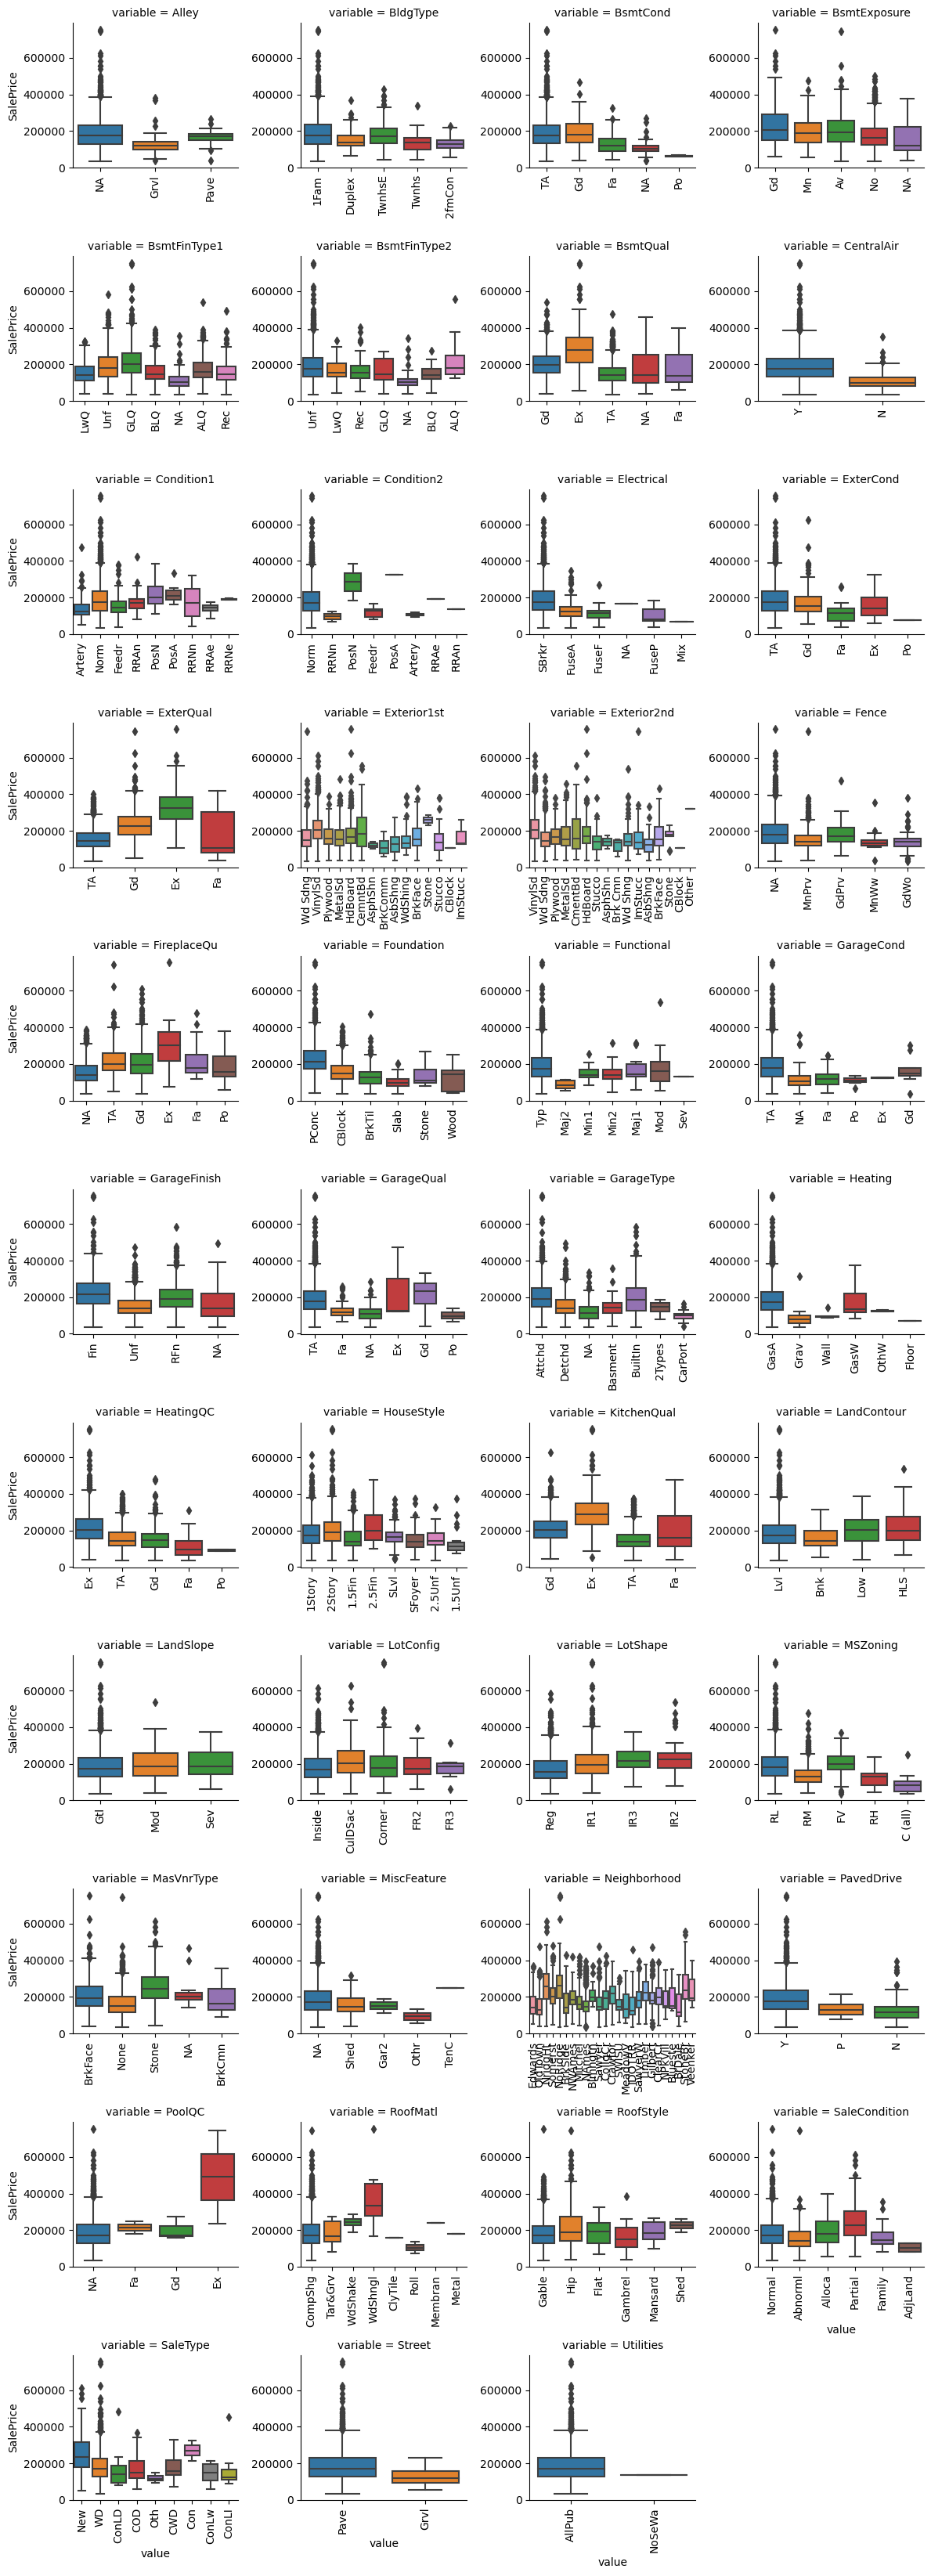

In [48]:
p = pd.melt(cat_data, id_vars='SalePrice', value_vars=category_features) 
p = p.sort_values(by='variable')
g = sns.FacetGrid (p, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(boxplot, 'value','SalePrice')
g

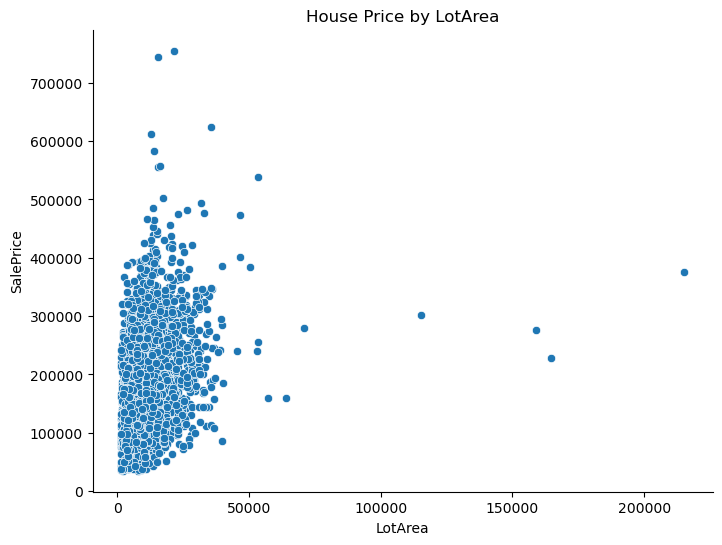

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LotArea', y='SalePrice', data=pdf)
title = plt.title('House Price by LotArea')
sns.despine()

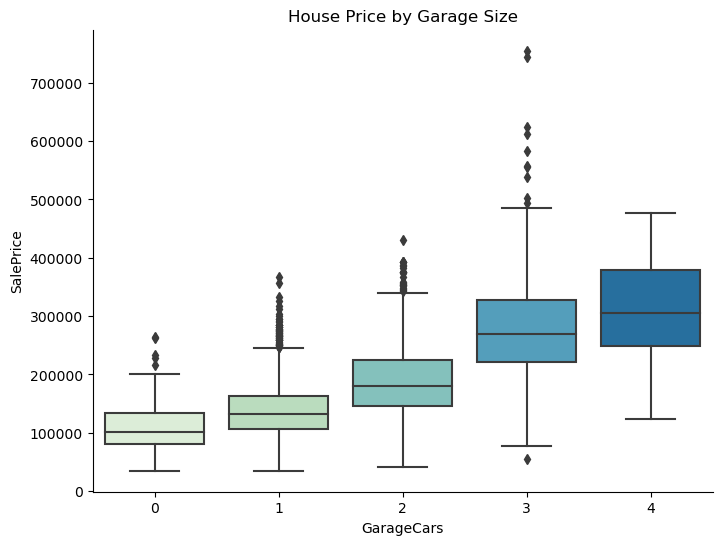

In [50]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=pdf, palette='GnBu')
title = plt.title('House Price by Garage Size')
sns.despine()

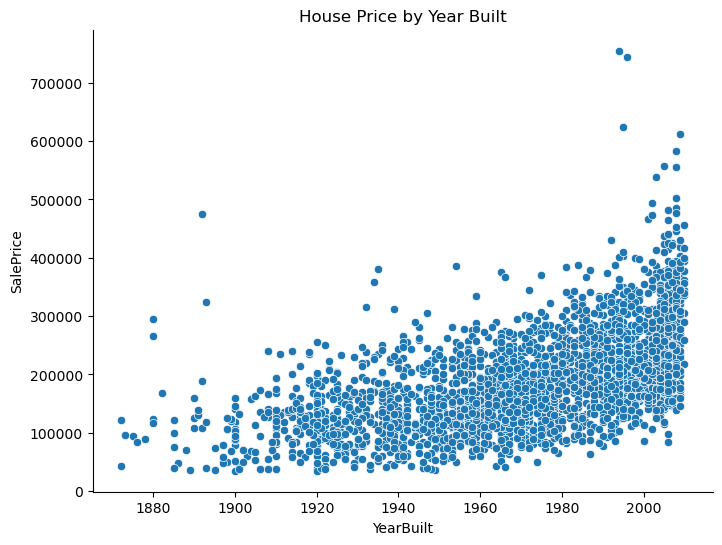

In [51]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=pdf)
title = plt.title('House Price by Year Built')
sns.despine()

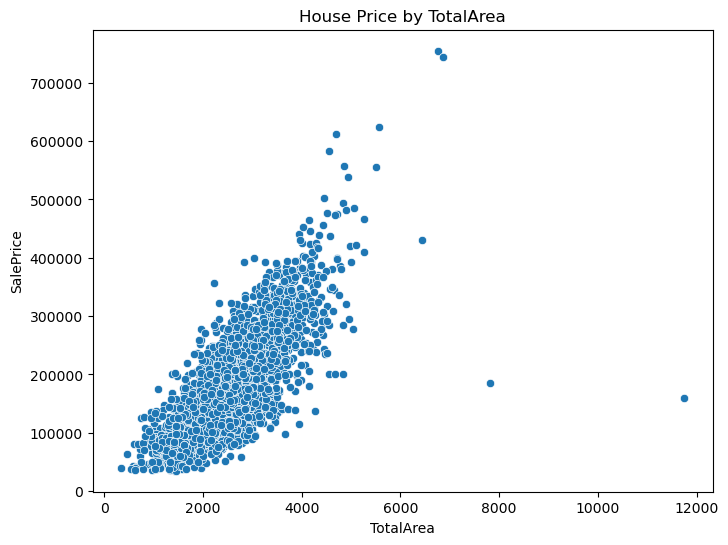

In [52]:
plt.figure(figsize=(8, 6))
pdf["TotalArea"] = pdf["GrLivArea"] + pdf["TotalBsmtSF"]
sns.scatterplot(x='TotalArea', y='SalePrice', data=pdf)
title = plt.title('House Price by TotalArea')

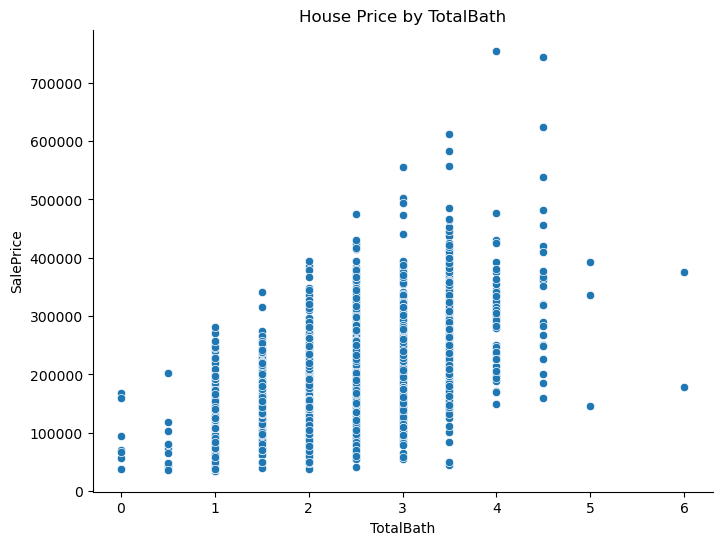

In [53]:
plt.figure(figsize=(8, 6))
pdf["TotalBath"] = pdf["FullBath"] + 0.5*pdf["HalfBath"] + pdf["BsmtFullBath"] + 0.5*pdf["BsmtHalfBath"]
sns.scatterplot(x='TotalBath', y='SalePrice', data=pdf)
title = plt.title('House Price by TotalBath')
sns.despine()

### Feature Engineering

In [54]:
def add_new_features(df):
    """function to add new features and returns dataframe"""
    df = df.withColumn("TotalBath", df["FullBath"] + 0.5*df["HalfBath"] + df["BsmtFullBath"] + 0.5*df["BsmtHalfBath"])
    df = df.withColumn("TotalArea", df["GrLivArea"] + df["TotalBsmtSF"])
    df = df.withColumn("TotalFloorSF",df['1stFlrSF'] + df['2ndFlrSF'])
    df = df.withColumn("RemodelledAge",  df['YearRemodAdd']-df['YearBuilt'])
    df = df.withColumn("Age",  2010 -df['YearBuilt'])
    df = df.withColumn("IsRegularLotShape" , F.when(df.LotShape ==  "Reg","1").otherwise("0")) 
    df = df.withColumn("IsRemodeled" , F.when(df.YearBuilt !=  df.YearRemodAdd,"1").otherwise("0")) 
    df = df.withColumn("VeryNewHouse" , F.when(df.YearBuilt ==  df.YrSold,"1").otherwise("0")) 
    df = df.withColumn("TotalPorchSF", df["OpenPorchSF"] + df["EnclosedPorch"]+df["3SsnPorch"] + df["ScreenPorch"])
    df = df.drop("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath","1stFlrSF","2ndFlrSF","GrLivArea","TotalBsmtSF")
    df = df.drop('OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','YearRemodAdd','YearBuilt')
    return df

In [55]:
def convert_features(df):
    """function to convert features and returns dataframe"""
    for col_name in COLS_TO_UPPER:
        df =  df.withColumn(col_name,F.upper(F.col(col_name)))
        
    df = df.replace(BASEMENT_FINISH_CONVERTER,subset=['BsmtFinType1', 'BsmtFinType2'])
    df = df.replace(QUALITY_CONVERTER,subset=QUALITY_COLS)
    df = df.replace(GARAGE_FINISH_MAP,subset=['GarageFinish'])
    df = df.replace(BSMTEXPOSURE_MAP,subset=['BsmtExposure'])
    df = df.replace(MSSUBCLASS_MAP,subset=['MSSubClass'])
    df = df.replace(SALECONDITION_MAP,subset=['SaleCondition'])
    df = df.replace(FENCE_MAP,subset=['Fence'])
    
    for col in COLS_TO_INT:
        df = df.withColumn(col,F.col(col).cast('integer'))
    return df

In [56]:
df = add_new_features(df)

In [57]:
df = convert_features(df)

In [58]:
df.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-------+---------+----------+----------+------------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+---------+---------+------------+-------------+---+-----------------+-----------+------------+------------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|Ro

In [59]:
corr_df =  df.toPandas().corr()
corr_mat =corr_df.SalePrice.sort_values(ascending=False)
corr_mat.head(15) 

/tmp/ipykernel_39232/1040163610.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df =  df.toPandas().corr()


SalePrice       1.000000
OverallQual     0.789605
TotalArea       0.776797
TotalFloorSF    0.712912
TotalBath       0.602900
GarageArea      0.586093
GarageCars      0.577508
ExterQual       0.541423
TotRmsAbvGrd    0.517826
KitchenQual     0.461894
Fireplaces      0.429321
FireplaceQu     0.370671
MasVnrArea      0.367145
HeatingQC       0.363982
WoodDeckSF      0.352796
Name: SalePrice, dtype: float64

In [60]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rdf = df.toPandas() 
y = rdf['SalePrice']
X = rdf.drop('SalePrice', axis ="columns")
rfe = RFE(estimator, n_features_to_select=20, step=1)
selector = rfe.fit(X.fillna(0).select_dtypes(exclude='object'), y)
selectedFeatures = list(X.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'SaleCondition',
 'TotalBath']

In [61]:
def add_log_sale_price(df):
    """function to add column LogSalePrice and returns dataframe"""
    df = df.withColumn("LogSalePrice", F.log10(F.col("SalePrice")))
    return df

    
def get_cat_and_cont_features(df,exclude_cols=None):
    """function to return categorical and continous features"""
    category_features = [f.name for f in df.schema.fields if isinstance(f.dataType, T.StringType)]
    ignore_cols  = category_features + exclude_cols if exclude_cols else category_features
    category_features = category_features + ORDINAL_CATEGORY_FEATURES
    continuous_features = [ f.name for f in df.schema.fields if f.name not in ignore_cols]
    return category_features,continuous_features

In [62]:
df = add_log_sale_price(df)

In [63]:
df.select(["SalePrice","LogSalePrice"]).show(5)

+---------+------------------+
|SalePrice|      LogSalePrice|
+---------+------------------+
|   208500| 5.319106059309776|
|   181500| 5.258876629372131|
|   223500| 5.349277527467955|
|   140000| 5.146128035678238|
|   250000|5.3979400086720375|
+---------+------------------+
only showing top 5 rows



In [64]:
category_features,continuous_features = get_cat_and_cont_features(df,EXCLUDE_COLS)

In [65]:
df.select(category_features).show(5) 

+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+----------+-------+----------+----------+----------+----------+----------+-----------+--------+-----------------+-----------+------------+-----------+------+------+
|MSZoning|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|Foundation|Heating|CentralAir|Electrical|Functional|GarageType|PavedDrive|MiscFeature|SaleType|IsRegularLotShape|IsRemodeled|VeryNewHouse|GarageYrBlt|MoSold|YrSold|
+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+----------+-------+----------+----------+----------+----------+----------+-----------+--------+-----------------+--------

In [66]:
cat_pdf = df.select(category_features+["SalePrice"]).toPandas()

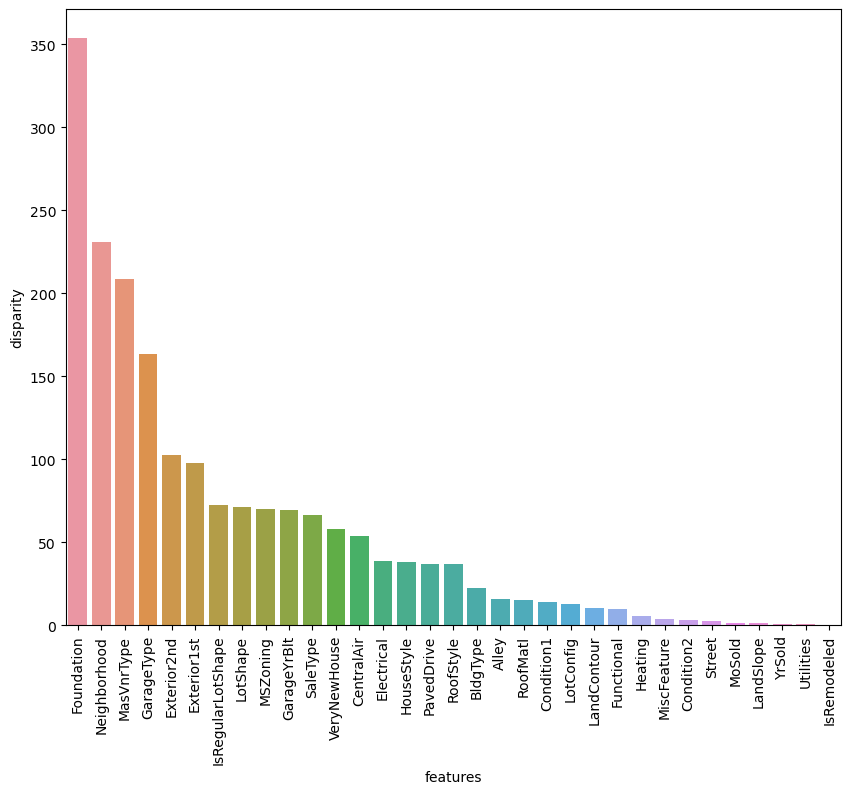

In [67]:
from scipy import stats

def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = category_features
    pvals = []
    for c in category_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

 
k = anova(cat_pdf) 
k['disparity'] = np.log(1./k['pval'].values) 

plt.figure(figsize=(10,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt.show()

In [68]:
selected_categories = list(k['features'][:16])

In [69]:
df.select(continuous_features).show(5) 

+----------+-----------+-------+-----------+-----------+----------+---------+---------+--------+--------+------------+------------+----------+------------+----------+---------+---------+------------+------------+------------+-----------+------------+----------+-----------+-----------+------------+----------+----------+----------+----------+----------+--------+------+-----+-------+------+------+-------------+---------+---------+------------+-------------+---+------------+
|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|MasVnrArea|ExterQual|ExterCond|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinSF1|BsmtFinType2|BsmtFinSF2|BsmtUnfSF|HeatingQC|LowQualFinSF|BedroomAbvGr|KitchenAbvGr|KitchenQual|TotRmsAbvGrd|Fireplaces|FireplaceQu|GarageYrBlt|GarageFinish|GarageCars|GarageArea|GarageQual|GarageCond|WoodDeckSF|PoolArea|PoolQC|Fence|MiscVal|MoSold|YrSold|SaleCondition|TotalBath|TotalArea|TotalFloorSF|RemodelledAge|Age|TotalPorchSF|
+----------+-----------+-------+-----------+----

In [70]:
print(f"number of rows: {df.count()} and number of columns: {len(df.columns)}")

number of rows: 2960 and number of columns: 77


In [71]:
null_counts = get_null_counts(df)
null_counts

{}

### Data Preprocessing Pipeline
Data preprocessing is done to make it ready for building machine learning model 
which are required to make the dataset ready to be sent it across the ML pipeline where the model could easily adapt it and build an efficient model.

String Indexing, one hot encoding, vector assembling,scaling, feature selection.

In [72]:
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.regression import LinearRegression,LinearRegressionModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.feature import UnivariateFeatureSelector

In [97]:
def create_pipeline(category_features,continuous_features,add_vector_index=False):
    """function to create pipeline based on categorical and continous features and returns pipeline"""
    str_enc = [ f"{col}_str_enc" for col in category_features]
    ohe_enc = [ f"{col}_ohe" for col in category_features]
    stage_str_enc = [StringIndexer(inputCol=a, outputCol= b,handleInvalid="keep") for a,b in zip(category_features,str_enc)]
    stage_ohe_enc = [OneHotEncoder(inputCol= a, outputCol= b) for a,b in zip(str_enc,ohe_enc) ]
    next_input_col = 'indexed_features' if add_vector_index else 'features'
    
    if add_vector_index:
        stage_vec_assembler = VectorAssembler(inputCols= continuous_features + str_enc ,outputCol="features")
        stage_indexer =    VectorIndexer(inputCol= "features", outputCol= "indexed_features",handleInvalid="keep")
    else:
        stage_vec_assembler = VectorAssembler(inputCols= continuous_features + ohe_enc ,outputCol="features")
    
        
    stage_scaler = RobustScaler(inputCol=next_input_col,outputCol="scaled_features")
    stage_selector = UnivariateFeatureSelector(featuresCol='scaled_features',
                                           outputCol="selected_features",
                                           labelCol="SalePrice",
                                           )

    stage_selector.setFeatureType("continuous").setLabelType("continuous") 
    if add_vector_index:
        pipeline_stages  = stage_str_enc + [stage_vec_assembler,stage_indexer,stage_scaler]
    else:
        pipeline_stages  = stage_str_enc + stage_ohe_enc + [stage_vec_assembler,stage_scaler]
    pipeline = Pipeline(stages= pipeline_stages)
    return pipeline

In [74]:
pipeline  = create_pipeline(category_features,continuous_features,add_vector_index=False)

In [75]:
train_df, test_df =  df.randomSplit([0.7,0.3], seed = 42)

In [76]:
print("Observations in training set = ", train_df.count())
print("Observations in testing set = ", test_df.count())

Observations in training set =  2114
Observations in testing set =  846


In [77]:
pipeline_model = pipeline.fit(train_df)
train_pdf = pipeline_model.transform(train_df)

In [78]:
train_pdf = pipeline_model.transform(train_df)

In [79]:
test_pdf = pipeline_model.transform(test_df)

In [80]:
lr =  LinearRegression(featuresCol="scaled_features", labelCol="SalePrice",maxIter= 250,regParam=0.05, elasticNetParam=1)

In [81]:
lr_model = lr.fit(train_pdf)

trainingSummary = lr_model.summary
trainingSummary.residuals.show()

trainingSummary = lr_model.summary
print(f"RMSE: {trainingSummary.rootMeanSquaredError:.4f}")
print(f"r2: {trainingSummary.r2:.4f}")

+-------------------+
|          residuals|
+-------------------+
|-13992.627992981346|
|-17451.113242427702|
| -43339.81034302269|
| -46041.06615916826|
| -23243.51159379899|
|-45874.826976439566|
|  16644.21224399691|
| -5944.658986105584|
|  31751.39692926884|
| -1545.620247404906|
|-14276.012888505706|
|  2283.845557501423|
|  14759.12107209058|
|-19886.411723688827|
| -4993.175224455656|
| 8036.0391063566785|
| 24028.314505013637|
| 23167.679283982376|
|  5724.962185197277|
|  -4365.01228164183|
+-------------------+
only showing top 20 rows

RMSE: 34918.0506
r2: 0.8154


In [82]:
lr_model

LinearRegressionModel: uid=LinearRegression_d32c48cd0b5c, numFeatures=342

In [83]:
test_prediction= lr_model.transform(test_pdf)

In [84]:
eval_lr = RegressionEvaluator(predictionCol='prediction', labelCol='SalePrice')


In [85]:
rmse= eval_lr.evaluate(test_prediction, {eval_lr.metricName:'rmse'})
r2 =eval_lr.evaluate(test_prediction,{eval_lr.metricName:'r2'})

print(f"RMSE: {rmse:.4f}")
print(f"r2: {r2:.4f}")

RMSE: 33880.3176
r2: 0.8211


In [86]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
lr = LinearRegression(labelCol="SalePrice", featuresCol="scaled_features")

lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.05, 0.09,0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0,  0.5,  1.0])
             .addGrid(lr.maxIter, [ 100,250])
             .build())

lrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="SalePrice", metricName="rmse")

# Create 5-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = lrevaluator,
                    numFolds = 5)

# Run cross validations
lrcvModel = lrcv.fit(train_pdf)
print(lrcvModel)

# Get Model Summary Statistics


predictions_train = lrcvModel.bestModel.transform(train_pdf)


rmse= eval_lr.evaluate(predictions_train, {eval_lr.metricName:'rmse'})
r2 =eval_lr.evaluate(predictions_train,{eval_lr.metricName:'r2'})

print(f"RMSE: {rmse:.4f}")
print(f"r2: {r2:.4f}")

test_prediction= lrcvModel.bestModel.transform(test_pdf)

rmse= eval_lr.evaluate(test_prediction, {eval_lr.metricName:'rmse'})
r2 =eval_lr.evaluate(test_prediction,{eval_lr.metricName:'r2'})

print(f"RMSE: {rmse:.4f}")
print(f"r2: {r2:.4f}")

In [98]:
tr_pipeline = create_pipeline(category_features,continuous_features,add_vector_index=True)

In [99]:
tr_pipeline_model = tr_pipeline.fit(train_df)

In [100]:
train_tpdf = tr_pipeline_model.transform(train_df)

In [101]:
test_tpdf = tr_pipeline_model.transform(test_df)

In [102]:
gbt = GBTRegressor(labelCol="SalePrice",featuresCol="scaled_features", maxIter=10)

In [103]:
gbt_model = gbt.fit(train_tpdf)



In [104]:
test_prediction= gbt_model.transform(test_tpdf)

In [105]:
test_prediction.select("prediction","SalePrice").show(5)

+------------------+---------+
|        prediction|SalePrice|
+------------------+---------+
| 238126.2928606081|   223500|
|  301833.316052339|   307000|
|185637.39106153918|   129900|
|130632.18256090413|   118000|
|  193325.645267324|   279500|
+------------------+---------+
only showing top 5 rows



In [106]:

rmse= eval_lr.evaluate(test_prediction, {eval_lr.metricName:'rmse'})
r2 =eval_lr.evaluate(test_prediction,{eval_lr.metricName:'r2'})

print(f"RMSE: {rmse:.4f}")
print(f"r2: {r2:.4f}")

RMSE: 37748.5227
r2: 0.7779


In [107]:
 print(gbt_model) 

GBTRegressionModel: uid=GBTRegressor_1f4aa9efcd04, numTrees=10, numFeatures=77


In [ ]:
#df_exp = df.select('LogSalePrice').withColumn("ExpSalePrice", F.exp(F.col("LogSalePrice")))